In [1]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from itertools import chain

In [2]:
FILENAME = "first_names.all.txt"
N = 10

In [3]:
names = []
with open(FILENAME, "r") as f:
    for line in f:
        line = line.strip().lower()
        if not line or not line.isalpha():
            continue
        names.append(line)

chars = set()
for name in names:
    chars.update(name.strip())

len(chars), "".join(sorted(chars))

(87,
 'abcdefghijklmnopqrstuvwxyzßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþāăąćčďđēėęěğģīıĳķļľłņňőřşţťūżž')

In [4]:
before_start_chars = list(reversed([f"-{i}" for i in range(1, N + 1)]))
end_char = "<END>"

char_to_code = {
    c: i for i, c in
    enumerate([end_char] + before_start_chars + sorted(chars))
}
code_to_char = {
    v: k for k, v in char_to_code.items()
}

chars_total = len(char_to_code)

chars_total, list(char_to_code.items())[:N + 5]

(98,
 [('<END>', 0),
  ('-10', 1),
  ('-9', 2),
  ('-8', 3),
  ('-7', 4),
  ('-6', 5),
  ('-5', 6),
  ('-4', 7),
  ('-3', 8),
  ('-2', 9),
  ('-1', 10),
  ('a', 11),
  ('b', 12),
  ('c', 13),
  ('d', 14)])

In [5]:
dataset = []
for name in tqdm(names):
    lst = before_start_chars + list(name) + [end_char]
    codes = [char_to_code[c] for c in lst]
    dataset.append(np.array(codes))

100%|██████████| 157710/157710 [00:00<00:00, 168368.00it/s]


In [6]:
xs = []
ys = []
for name in tqdm(dataset):
    for pos in range(len(name) - N):
        x = tuple(name[pos : pos + N])
        y = name[pos + N]

        xs.append(x)
        ys.append(y)

xs_t = torch.tensor(xs)
ys_t = torch.tensor(ys)

xs_t.shape, ys_t.shape

100%|██████████| 157710/157710 [00:07<00:00, 20562.31it/s]


(torch.Size([1204945, 10]), torch.Size([1204945]))

In [7]:
batch_size = 25000

def reshuffle():
    x_batched = []
    y_batched = []

    global xs_t, ys_t
    perms = torch.randperm(xs_t.size(0))
    xs_t = xs_t[perms]
    ys_t = ys_t[perms]

    for i in list(range(0, len(xs_t), batch_size)):
        x = xs_t[i : i + batch_size]
        y = ys_t[i : i + batch_size]

        x_batched.append(x)
        y_batched.append(y)

    return x_batched, y_batched

x_batched, y_batched = reshuffle()
x_batched[0].dtype, y_batched[0].shape, len(x_batched), len(y_batched)

(torch.int64, torch.Size([25000]), 49, 49)

In [8]:
device = torch.device('cuda')
layers_n = 3
width = 3500
ws = []
bs = []

input_size = N * chars_total

for _ in range(layers_n):
    is_first = len(ws) == 0
    is_last = len(ws) == layers_n - 1

    isize = input_size if is_first else width
    osize = chars_total if is_last else width

    w = (torch.randn(isize, osize, device=device) * 0.01).requires_grad_(True)
    b = torch.zeros(osize, device=device, requires_grad=True)

    ws.append(w)
    bs.append(b)
#
# w1 = (torch.randn(input_size, 3500, device=device) * 0.01).requires_grad_(True)
# w2 = (torch.randn(3500, chars_total, device=device) * 0.01).requires_grad_(True)
#
# b1 = torch.zeros(3500, device=device, requires_grad=True)
# b2 = torch.zeros(chars_total, device=device, requires_grad=True)

[(w.shape, b.shape) for w, b in zip(ws, bs)]

[(torch.Size([980, 3500]), torch.Size([3500])),
 (torch.Size([3500, 3500]), torch.Size([3500])),
 (torch.Size([3500, 98]), torch.Size([98]))]

In [9]:
loss_history = []

In [19]:
rate = 0.04
reg = 0.02

for i in tqdm(list(range(10))):
    x_batched, y_batched = reshuffle()

    for x_batch, y_batch in zip(x_batched, y_batched):

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        r = F.one_hot(x_batch, num_classes=chars_total).flatten(start_dim=1).float()

        for layer_i, (w, b) in enumerate(zip(ws, bs)):
            is_last = layer_i == layers_n - 1

            r = r @ w + b
            if not is_last:
                r = r.relu()
            else:
                r = r.softmax(dim=1)

        truth = r[torch.arange(len(y_batch), device=device), y_batch]
        #regularization = reg*((w1**2).mean() + (w2**2).mean() + (b1**2).mean() + (b2**2).mean())
        regularization = reg * sum((w**2).mean() + (b**2).mean() for w, b in zip(ws, bs))
        loss = -torch.log(truth).mean() + regularization

        loss_history.append(loss.item())

        for w, b in zip(ws, bs):
            w.grad = None
            b.grad = None
        loss.backward()

        # update weights
        with torch.no_grad():
            for w, b in zip(ws, bs):
                w -= rate * w.grad
                b -= rate * b.grad

100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


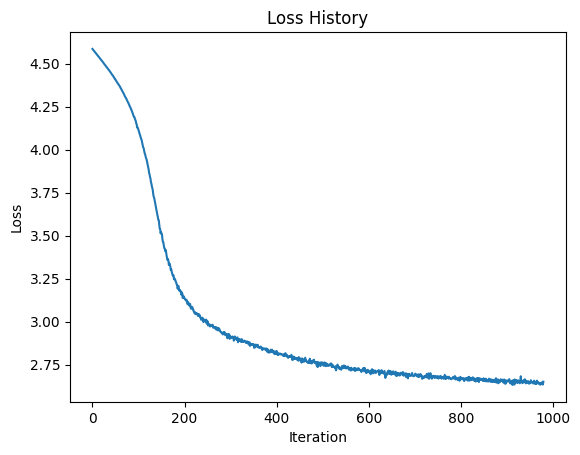

In [20]:
# plot loss_history
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()

In [21]:
import os
def generate_name() -> str:
    with torch.no_grad():
        prev = [char_to_code[c] for c in before_start_chars]
        while True:
            prev_tensor = torch.tensor(prev, dtype=torch.int64, device=device)
            distribution_tensor = torch.tensor(prev_tensor, dtype=torch.int64, device=device)
            r = F.one_hot(distribution_tensor, num_classes=chars_total).view(-1).float().to(device)

            for layer_i, (w, b) in enumerate(zip(ws, bs)):
                is_last = layer_i == layers_n - 1

                r = r @ w + b
                if not is_last:
                    r = r.relu()
                else:
                    r = r.softmax(dim=0)

            next_char = torch.multinomial(r, num_samples=1).item()

            if next_char in [char_to_code[c] for c in chain(before_start_chars, [end_char])]:
                break

            yield next_char
            prev = prev[1:] + [next_char]


In [22]:
for _ in range(11):
    print("".join(code_to_char[c] for c in generate_name()))


vomhly
neooeila
kezioa
tdpiin
yaralia
aurmi
jlsuenra
saama
jeila
lrguasea
daanna


/tmp/ipykernel_3180619/2612326761.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distribution_tensor = torch.tensor(prev_tensor, dtype=torch.int64, device=device)
